In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

%run backwards_time_voter_model.ipynb

## Load data

In [11]:
# Define parameters same as in run notebook
alpha = 3e-4
L = 500

In [12]:
# Create list to load results into 
grids = []
species_lens = []

# Loop over all 20 grids that were created previously
for i in range(1, 21):
    # Load pickle file
    species_load = pickle.load(open(f"Basic model runs/{500}x{500},alpha={alpha},kernel=nearest.p_{i}", "rb" ))
    
    # Assign each specie unique id
    species_ids = np.random.uniform(size=len(species_load))
    grid = np.zeros((L, L))
    # Set each coordinate belonging to species to unique id
    species_len = []
    for i, specie in enumerate(species_load):
        species_len.append(len(specie))
        for coord in specie:
            grid[coord] = species_ids[i]
    grids.append(grid)
    species_lens.append(species_len)

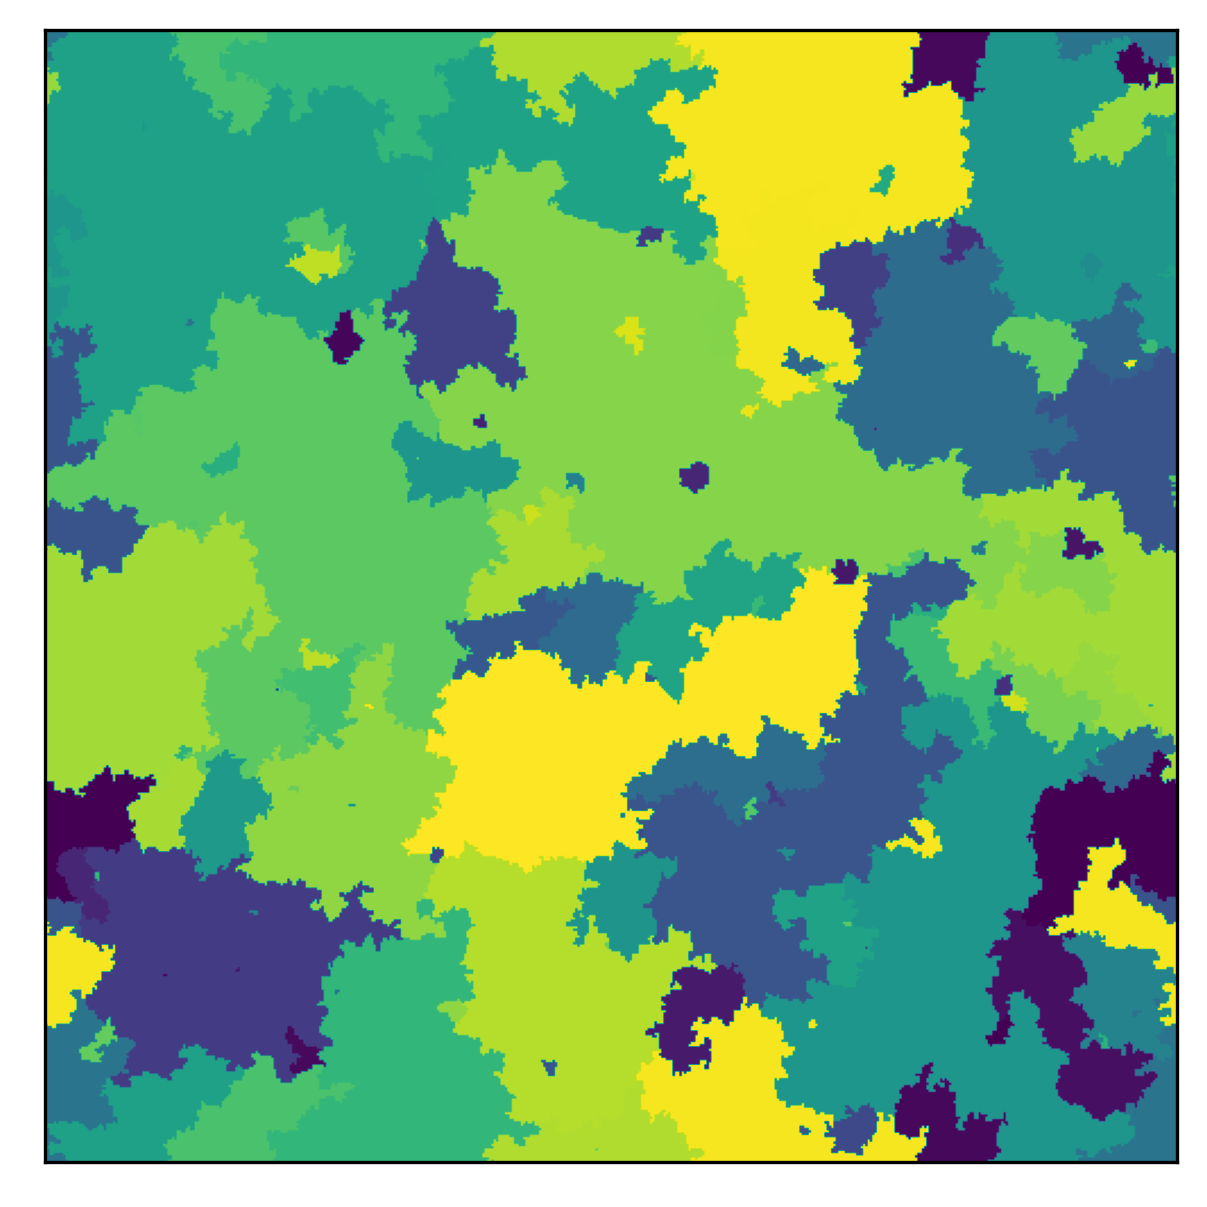

In [13]:
# Visualize one grid as an example
plt.figure(figsize=(5, 5))
plt.imshow(grids[3])
plt.xticks([])
plt.yticks([])
plt.show()

# Create Visualisations

In [14]:
# Calculate species area curves
areas = []
num_species = []

n_centers = 10
for grid in grids:
    areas, cur_num_species = sa_curve(grid, n_centers)
    num_species = num_species + cur_num_species
    
# Calculate mean and standard deviation
spec_std_dev = np.std(num_species, axis=0)
spec_mean = np.mean(num_species, axis=0)

In [15]:
def power_law(A, c, z):
    '''Calculate power law distribution'''
    return c*A**z

In [16]:
from scipy.stats import kstest
from scipy.optimize import curve_fit

# Calculate power law fit on right of the data
start = 60
# Perfrom KS test on the data and print P value
(fit_c, fit_z), pcov = curve_fit(power_law, areas[start:], spec_mean[start:], p0=[0.1, 1])
res = kstest(spec_mean[start:], fit_c*np.array(areas[start:])**fit_z)
print(res)

KstestResult(statistic=0.031578947368421054, pvalue=0.9999845206799127)


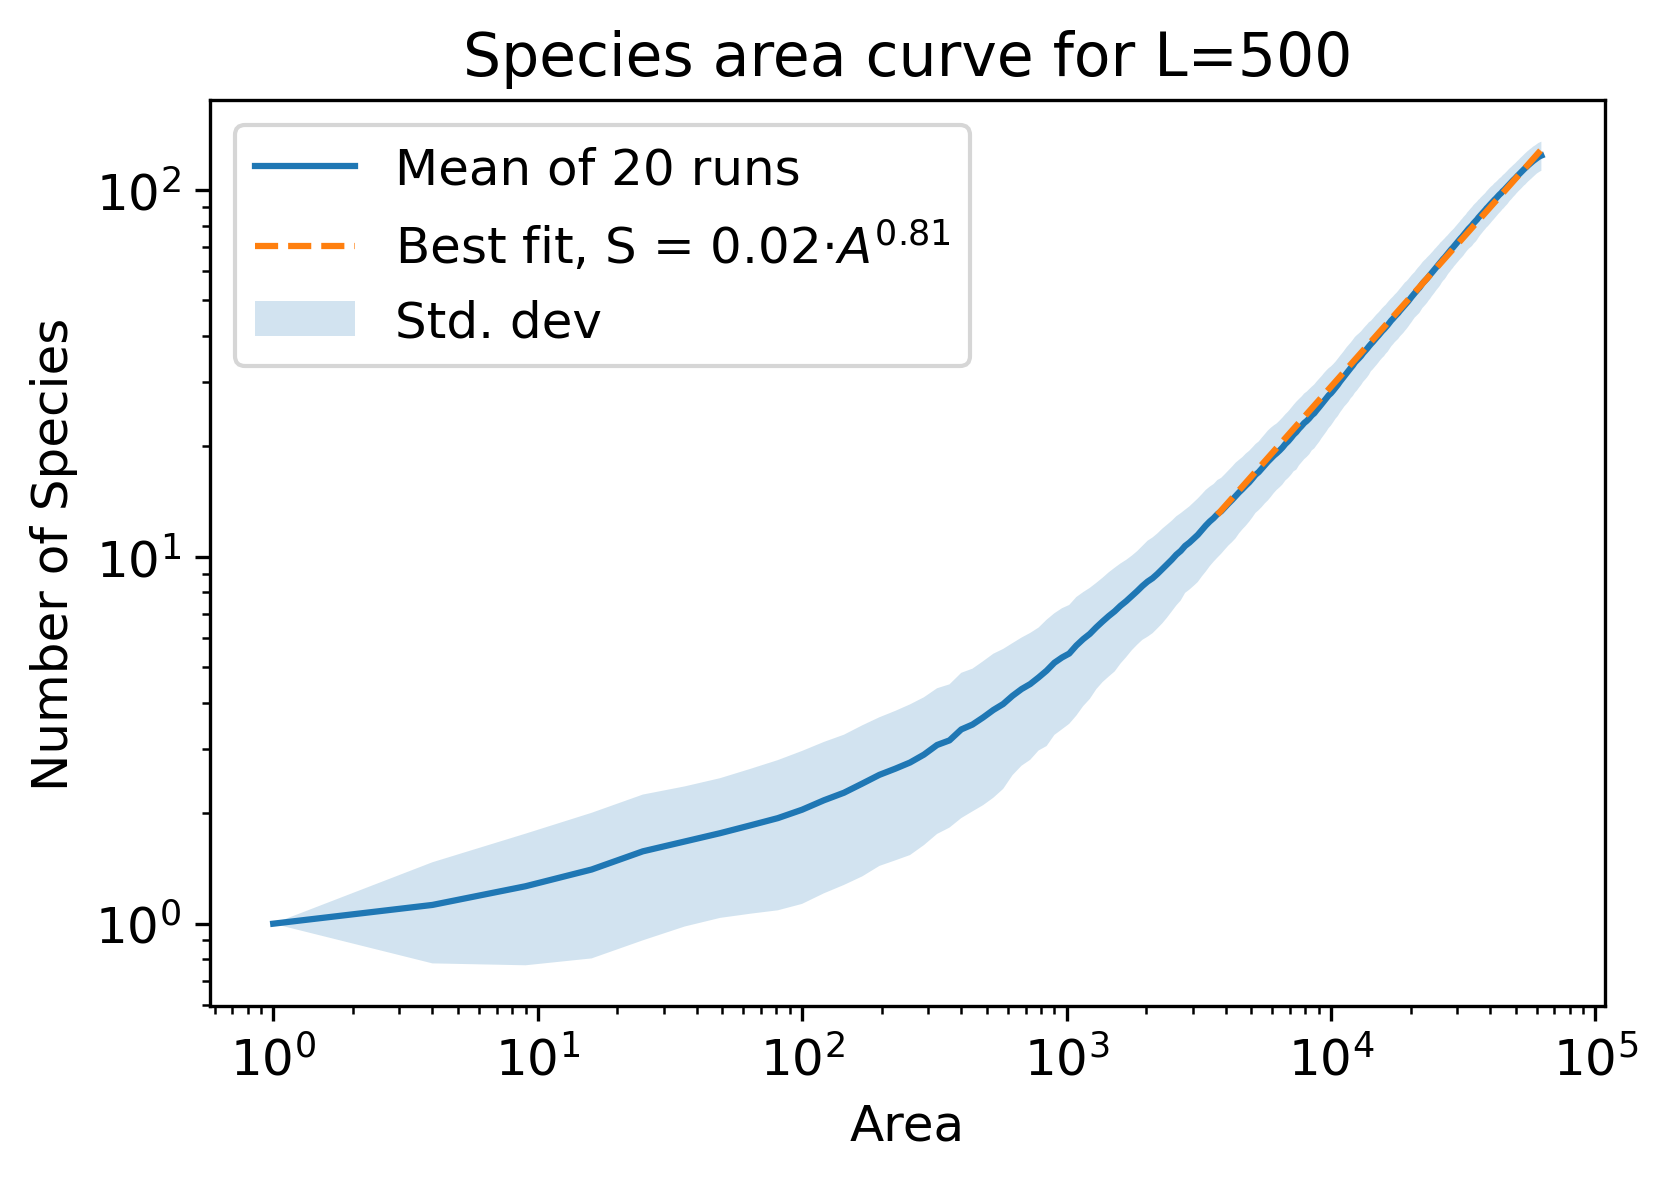

In [17]:
# Plot species area curve with fit
plt.loglog(areas, spec_mean, label='Mean of 20 runs')
plt.loglog([areas[start], areas[-1]],
           fit_c*np.array([areas[start], areas[-1]])**fit_z,
           linestyle='dashed',
           color='C1',
           label=rf'Best fit, S = {round(fit_c, 2)}$\cdot A^{{{round(fit_z, 2)}}}$')

plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label='Std. dev')
plt.ylabel('Number of Species')
plt.xlabel('Area')
plt.title(f'Species area curve for L={L}')
plt.legend()
plt.show()

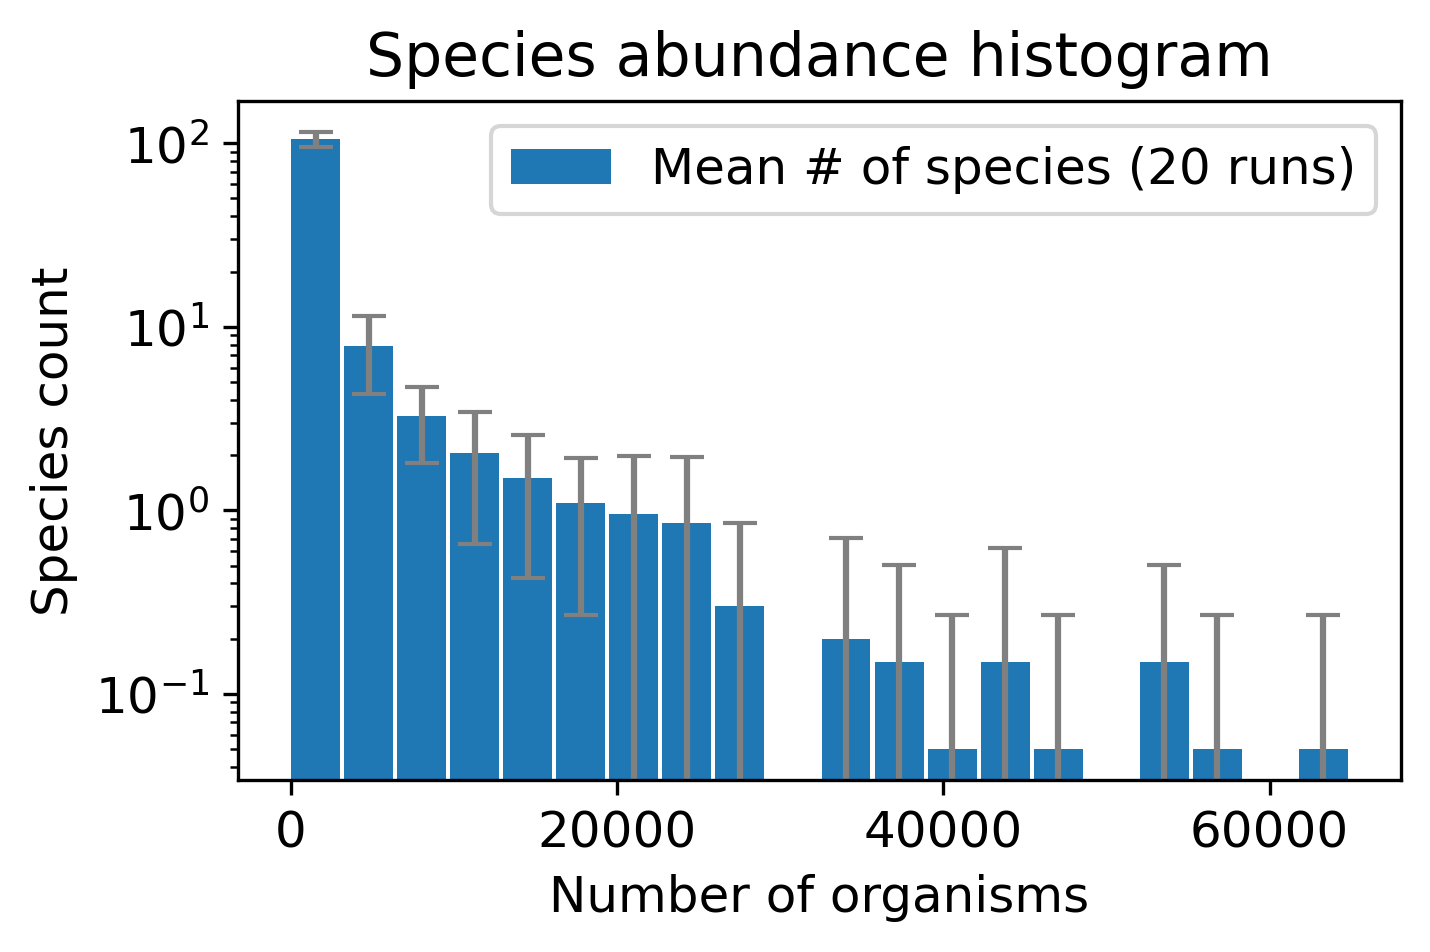

In [18]:
# Plot histogram of species abundance
plt.figure(figsize=(5, 3))

flat_species_lens = []

for species_len in species_lens:
    for length in species_len:
        flat_species_lens.append(length)

_, bins = np.histogram(flat_species_lens, bins=20)

hists = []

for species_len in species_lens:
    n, _ = np.histogram(species_len, bins=bins)
    hists.append(n)
    
mean_hist = np.mean(hists, axis=0)
std_hist = np.std(hists, axis=0)

plt.bar(bins[:-1],
        height=mean_hist,
        yerr=std_hist,
        capsize=4,
        ecolor='grey',
        width=3000, 
        label='Mean # of species (20 runs)',
        log=True,
        align='edge') 
plt.xlabel('Number of organisms')
plt.ylabel('Species count')
plt.title('Species abundance histogram')
plt.legend()
plt.show()